# Analysis of Data Science Jobs HR Agency Data

## Task description

Anylyse data and draw conclusions based on the received results. Ammend your reasoning with visualization. Using statistical analysis prove whether the conclusions are statistically significant.

In the course of your analysis you must:
1. Identify, which factors influence upon the salary of a data scientist.
2. Answer the key questions of the HR agency:
* Is there a yearly salary growth for the data science jobs?
* Is there a relation between the salaries of the data scientist and data engineer jobs in 2022?
* What is the relation between the data scientist salary and the company size?
* Is there an interrelation between the company size and the presence of the data scientist or data engineer jobs in it?

If you find other interesting patterns in the data, also mention them in your analysis.

Demonstrate usage of different statistical tests to check the statistical significance of your conclusions.
* Tests for a numeric feature:
    * One-sample group tests
    * Two-sample groups tests
    * Multiple sample groups tests
* Tests for a categorical feature.

## Dataset

For the analysis we use use the [Data Science Job Salaries](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries) dataset from Kaggle.

Data contains the following columns:
* work_year: year in which the salary has been paid
* experience_level: experience level on this role. The following values are possible:
    * EN — Entry-level/Junior
    * MI — Mid-level/Intermediate
    * SE — Senior-level/Expert
    * EX — Executive-level/Director
* employment_type: employment type for this role. The following values are possible:
    * PT — part time
    * FT — full time
    * CT — contract
    * FL — freelancer
* job_title: title of the role
* salary: brutto salary
* salary_currency: currency in which the salary has been paid (ISO 4217)
* salary_in_usd: salary value converted to USD using the yearly average exchange rate from fxdata.foorilla.com
* employee_residence: main residence country of the employee during the given year (ISO 3166)
* remote_ratio: ration of work which has been done remotely. The following values are possible:
    * 0 — no remove work (< 20 %)
    * 50 — partially remote work (>= 20 % and <= 80 %)
    * 100 — mainly remote work (> 80 %)
* company_location: country of the main employer office (ISO 3166)
* company_size:	average amount of people who worked in the company during the given year. The following values are possible:
    * S — < 50 employees (small company)
    * M — >= 50 and <= 250 employees (middle-size company)
    * L — > 250 employees (large company)

## Import of libraries

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import sys

sys.path.append('../')

from DataScienceHelpers.DataCleaningAttributes import find_low_information_attributes
from plotly.subplots import make_subplots


## Loading data

In [3]:
data = pd.read_csv('../data/ds_salaries.csv')
display(f'Number of records: {data.shape[0]}')
data.head()

'Number of records: 607'

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Data cleaning

### Empty cells
Identify empty cells and if necessary delete columns / rows which contain them.

In [4]:
data.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

The dataset does not contain empty cells.

### Low information features

Check if the dataset contains any low information features and delete those. For that I use the DataScienceHelpers library which I have developed in the course of the previous modules.

In [5]:
low_inf_attrs = find_low_information_attributes(data)
low_inf_attrs


[('Unnamed: 0', 1.0, 'nunique_ratio'),
 ('employment_type', 0.9686985172981878, 'top_freq')]

The 'Unnamed: 0' is an external index column, which contains 100 % unique values. This column can be safely dropped, because pandas generates a new index for us while reading data.

The 'employment_type' column contains a value, which is present in around 97 % of the rows. Let's check the frequency of the values of the 'employment_type' column.

In [6]:
data['employment_type'].value_counts()

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

The value 'FT' (full time job) is the most frequent one.

Since this feature is not mentioned in the task description, I will drop it in addition to 'Unnamed: 0'.

In [7]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('employment_type', axis=1, inplace=True)

### Duplicates

Check if the dataset contains any duplicates and delete those.

In [8]:
dupl_mask = data.duplicated()
dupl_data = data[dupl_mask]

number_with_duplicates = data.shape[0]
number_of_duplicates = dupl_data.shape[0]

data = data.drop_duplicates()
number_without_duplicates = data.shape[0]

display(f'Number or records with duplicates: {number_with_duplicates}')
display(f'Number of duplicates: {number_of_duplicates}')
display(f'Number or records without duplicates: {number_without_duplicates}')

'Number or records with duplicates: 607'

'Number of duplicates: 42'

'Number or records without duplicates: 565'

### Data type check

For each column check if the column data is matching the data type used within the dataframe.

In [9]:
display(data.head())
data.info()

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,Machine Learning Engineer,150000,USD,150000,US,50,US,L


<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   job_title           565 non-null    object
 3   salary              565 non-null    int64 
 4   salary_currency     565 non-null    object
 5   salary_in_usd       565 non-null    int64 
 6   employee_residence  565 non-null    object
 7   remote_ratio        565 non-null    int64 
 8   company_location    565 non-null    object
 9   company_size        565 non-null    object
dtypes: int64(4), object(6)
memory usage: 48.6+ KB


Column meaningful data types are matching the data types used in the dataframe.

### Classify feature by type (numeric or categorical)

* work_year - numeric
* experience_level - categorical
* job_title - N/A
* salary - numeric
* salary_currency - categorical
* salary_in_usd - numeric
* employee_residence - categorical
* remote_ratio - categorical
* company_location - categorical
* company_size - categorical

### Main statistical characteristics of the features

In [10]:
display('Statistic characteristics of the features:')
data.describe(include='all')

'Statistic characteristics of the features:'

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,565.000000,565,565,5.650000e+02,565,565.000000,565,565.000000,565,565
unique,NaN,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,SE,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,243,130,NaN,359,NaN,295,NaN,318,290
mean,2021.364602,NaN,NaN,3.381160e+05,NaN,110610.343363,NaN,69.911504,NaN,NaN
std,0.698138,NaN,NaN,1.599879e+06,NaN,72280.702792,NaN,40.900666,NaN,NaN
min,2020.000000,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.000000,NaN,NaN
25%,2021.000000,NaN,NaN,6.700000e+04,NaN,60757.000000,NaN,50.000000,NaN,NaN
50%,2021.000000,NaN,NaN,1.109250e+05,NaN,100000.000000,NaN,100.000000,NaN,NaN
75%,2022.000000,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.000000,NaN,NaN


## Exploratory data analysis

### Visual data analysis

Basic viaualization of all features available in the dataframe. Numeric features are visualized using Q-Q plots and histograms, categorical and text features are visualized using bar charts.

'Visualizing numeric features:'

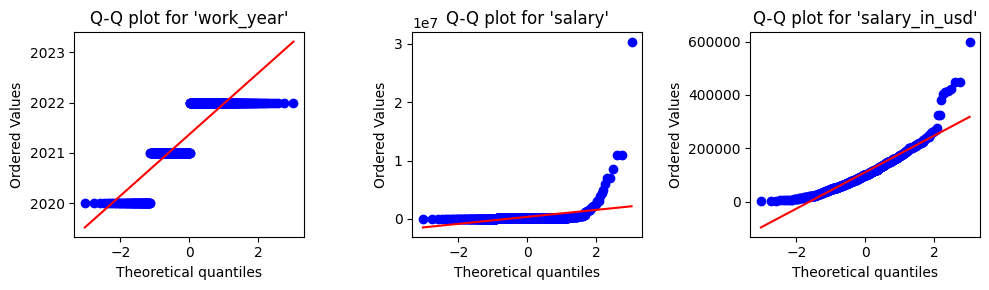

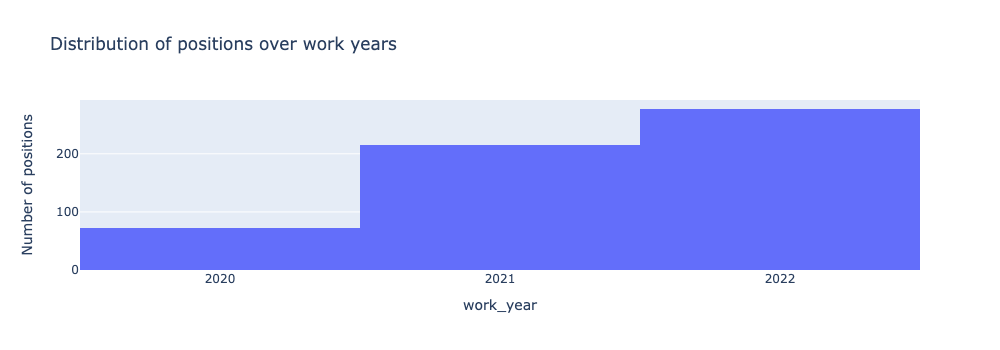

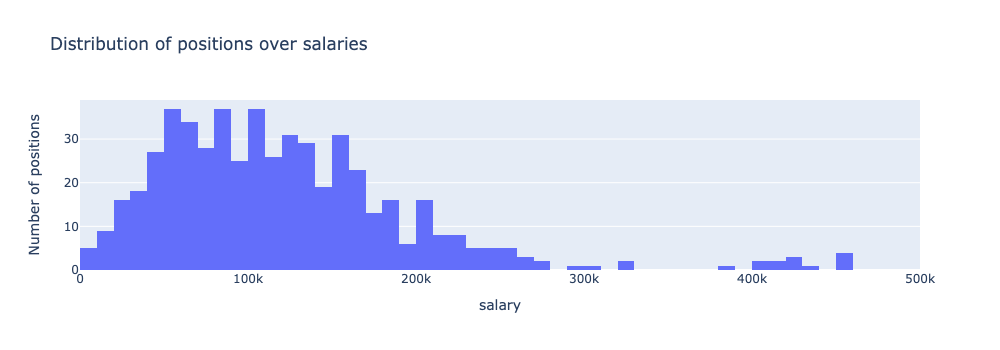

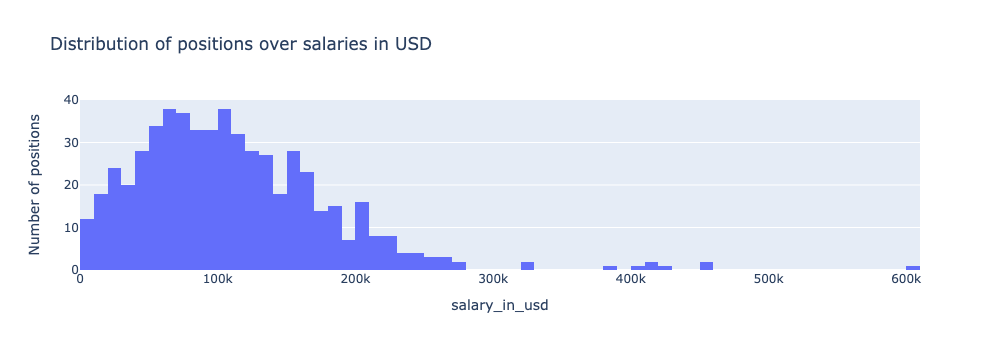

In [21]:
display('Visualizing numeric features:')

# Q-Q plots
plt.subplots(1, 3, figsize=(10, 3))

ax = plt.subplot(1, 3, 1)
stats.probplot(data['work_year'], plot=plt)
ax.set_title('Q-Q plot for \'work_year\'')

ax = plt.subplot(1, 3, 2)
stats.probplot(data['salary'], plot=plt)
ax.set_title('Q-Q plot for \'salary\'')

ax = plt.subplot(1, 3, 3)
stats.probplot(data['salary_in_usd'], plot=plt)
ax.set_title('Q-Q plot for \'salary_in_usd\'')

plt.tight_layout()
plt.show()

# Histograms
fig = px.histogram(
    data_frame=data,
    x='work_year',
    width=1000,
    height=350,
    title='Distribution of positions by work years'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_tickvals=[*range(int(data['work_year'].min()), int(data['work_year'].max())+1)]
)
fig.show('png')

fig = px.histogram(
    data_frame=data,
    x='salary',
    width=1000,
    height=350,
    nbins=5000,
    title='Distribution of positions by salaries'
).update_layout(
    yaxis_title='Number of positions',
    xaxis_range=[0, 500000]
)
fig.show('png')

fig = px.histogram(
    data_frame=data,
    x='salary_in_usd',
    width=1000,
    height=350,
    nbins=100,
    title='Distribution of positions by salaries in USD'
).update_layout(
    yaxis_title='Number of positions'
)
fig.show('png')

'Visualizing categorical and text features:'

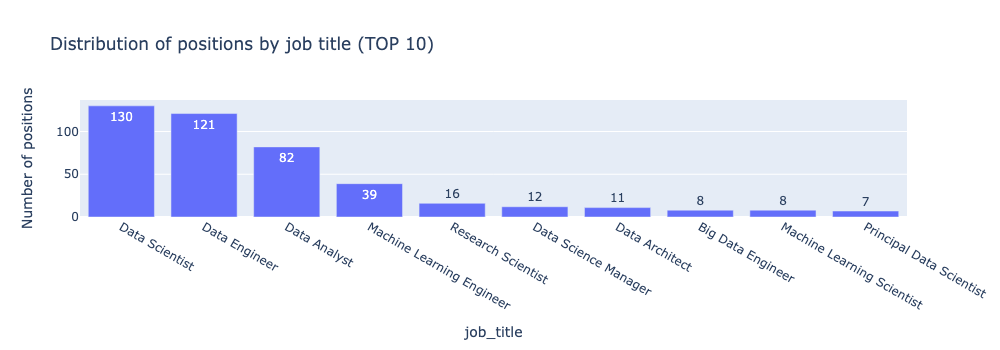

In [37]:
display('Visualizing categorical and text features:')

fig = px.bar(
    data['experience_level'].value_counts(),
    width=1000,
    height=350,
    title='Distribution of positions by experience level',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    xaxis_categoryorder='array',
    xaxis_categoryarray=['EN', 'MI', 'SE', 'EX']
)
fig.show()

fig = px.bar(
    data_frame=data['job_title'].value_counts().head(10),
    width=1000,
    height=350,
    title='Distribution of positions by job title (TOP 10)',
    text_auto=True
).update_layout(
    yaxis_title='Number of positions',
    showlegend=False
)
fig.show('png')